## Part 1: Setup

__First get all the libraries we need.__

In [15]:
from bs4 import BeautifulSoup
import urllib
import nltk
import pandas as pd
from scipy.stats.mstats import zscore
from collections import Counter
import pandas as pd
from scipy.stats.mstats import zscore
import matplotlib
import matplotlib.pyplot as plt
import sys
%matplotlib inline  
import numpy as np

__We already calculated interkey interval data by using the data of A. Feit and V. Monaco, and will use our IKI (inter-key interval, or time it takes to press the combination of two keys) means as a proxy for difficulty. Go get that data and take a quick peek at it.__

In [16]:
bigram_difficulty = pd.read_csv("bigram_info.csv")
bigram_difficulty.set_index("bigram", inplace=True)
bigram_difficulty.head()

,count,sem,mean,std,skew,kurtosis
bigram,,,,,,
ab,2174,0.004692,0.226277,0.218775,12.462170,306.160973
ac,2547,0.003413,0.260614,0.172263,5.146331,45.517834
ad,2765,0.003912,0.264489,0.205721,5.098247,45.378822
ae,488,0.014587,0.390154,0.322239,3.633144,17.240849
af,905,0.006064,0.261814,0.182412,4.154982,29.901926


__What are the basic descriptive stats about our proxy for difficulty (time it takes to complete the bigram)? Let's examine the aggregate stats of the bigram info we bring into this project.__

In [17]:
bigram_difficulty.describe()

,count,sem,mean,std,skew,kurtosis
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,1644.825521,0.012018,0.229887,0.203513,6.338184,99.827966
std,2728.870981,0.010490,0.061878,0.073093,4.820778,177.209575
min,30.000000,0.000904,0.075362,0.058247,0.054509,-0.972322
25%,149.250000,0.003990,0.189189,0.154553,3.313153,14.917608
50%,587.000000,0.007985,0.220435,0.189857,4.989242,39.607876
75%,2015.000000,0.017518,0.262684,0.237390,7.811896,101.950446
max,25500.000000,0.047321,0.449976,0.618384,32.062669,1531.678670


__What bigrams are included here?  We tossed some out in a different script, due to small sample size or excessive standard error.__

In [18]:
bigram_difficulty.index.values

array(['ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak', 'al',
       'am', 'an', 'ao', 'ap', 'ar', 'as', 'at', 'au', 'av', 'aw', 'ax',
       'ay', 'az', 'ba', 'bb', 'be', 'bi', 'bl', 'bm', 'bo', 'br', 'bs',
       'bt', 'bu', 'by', 'ca', 'cc', 'ce', 'ch', 'ci', 'ck', 'cl', 'cn',
       'co', 'cr', 'ct', 'cu', 'cy', 'da', 'dd', 'de', 'df', 'dg', 'dh',
       'di', 'dj', 'dk', 'dl', 'dn', 'do', 'dr', 'ds', 'du', 'dv', 'dy',
       'ea', 'eb', 'ec', 'ed', 'ee', 'ef', 'eg', 'eh', 'ei', 'ek', 'el',
       'em', 'en', 'eo', 'ep', 'eq', 'er', 'es', 'et', 'ev', 'ew', 'ex',
       'ey', 'fa', 'fd', 'fe', 'ff', 'fg', 'fh', 'fi', 'fj', 'fk', 'fl',
       'fo', 'fr', 'fs', 'ft', 'fu', 'fw', 'fy', 'ga', 'ge', 'gf', 'gg',
       'gh', 'gi', 'gj', 'gl', 'gn', 'go', 'gr', 'gs', 'gt', 'gu', 'gy',
       'ha', 'hd', 'he', 'hf', 'hg', 'hi', 'hj', 'hl', 'hn', 'ho', 'hp',
       'hr', 'hs', 'ht', 'hu', 'hy', 'ia', 'ib', 'ic', 'id', 'ie', 'if',
       'ig', 'ik', 'il', 'im', 'in', 'io', 'ip', 'i

__We're only interested in the bigrams that appear in this info table -- bigrams about which we have good stats.__

In [19]:
desiredBigrams = bigram_difficulty.index.values

__Let's see what the distribution of IKI means (proxy for difficulty) looks like.__

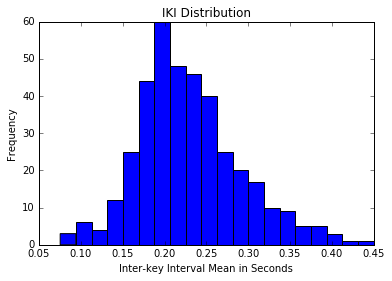

In [20]:
plt.hist(bigram_difficulty["mean"], bins = 20)
plt.xlabel('Inter-key Interval Mean in Seconds')
plt.ylabel('Frequency')
plt.title(r'IKI Distribution')
plt.show()

__It might come in handy to have a z-score, when it comes to measuring difficulty.__

In [21]:
bigram_difficulty['zscore'] = zscore(bigram_difficulty['mean'])
bigram_difficulty.head()

,count,sem,mean,std,skew,kurtosis,zscore
bigram,,,,,,,
ab,2174,0.004692,0.226277,0.218775,12.462170,306.160973,-0.058424
ac,2547,0.003413,0.260614,0.172263,5.146331,45.517834,0.497224
ad,2765,0.003912,0.264489,0.205721,5.098247,45.378822,0.559921
ae,488,0.014587,0.390154,0.322239,3.633144,17.240849,2.593419
af,905,0.006064,0.261814,0.182412,4.154982,29.901926,0.516641


__Now for NLTK Setup__

In [ ]:
# Set up the Natural Language Tool Kit
# This could take a while, just do it the one time, or skip if possible (i.e. you've got this installed already )
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

## Step 2: Web Scraping

__Web scraping requires us to be respectful of the intellectual property of and server impact to the owners of the site we're scraping.__

__We will crawl sites based on known sitemap architectures.  We do not attempt a full-fledged spidering of sites and do not follow links. __

__ For purposes of creating a minimum feasible product in a timely fashion, we limit ourselves only to WordPress sites.__

In [22]:
def getHTML(url):
    try:
        f = urllib.urlopen(url)
    except: 
        print "ERROR in " + url + " with exception " + str(sys.exc_info()[0])
        return(404)
    if f.getcode() != 200:
        return(404)
    htmltext = f.read()
    return(htmltext)

In [23]:
def parseWordpressSite(htmltext):
    soup = BeautifulSoup(htmltext, "lxml")

    # remove any .feedback (they're within our .post divs so we want them out so that "Comments", e.g., won't be included)
    for div in soup.find_all("p", {'class':'feedback'}): 
        div.decompose()

    # remove any .storydate (they're within our .post divs so we want them out, so that "March", e.g., won't be included)
    for div in soup.find_all(class_ = "storydate"): 
        div.decompose()

    # get only .post divs and .entry-content divs.
    posthtml = soup.find_all("div", class_="post") + soup.find_all("div", class_="entry-content")
    posttext = ""
    for post in posthtml:
        posttext += post.getText()
    return(posttext)

In [24]:
def scrapeBlog (blog):
        year=2016
        month=5
        blogstring = ""
        # recursively construct a single text that combines all blog text from this blogger from 2011-present
        while year > 2010:
            page = site.strip() + str("%04d" % (year)) + "/" + str("%02d" % (month))
            if month==1 :
                month = 12
                year = year - 1
            else:
                month = month - 1
            htmltext = getHTML(page)
            if htmltext==404:  
                continue     # go to the next month.
            poststring = parseWordpressSite(htmltext).encode("utf8")
            blogstring = blogstring + " " + poststring
        # remove and replace smart quotes, unreadable characters, new line chars, etc.
        blogstring = blogstring.replace("\xe2\x80\x9c", "'").replace("\xe2\x80\x9d", "'") 
        blogstring = blogstring.replace('\xe2\x80\x92', " ").replace('\xe2\x80\x93', " ").replace('\xe2\x80\x94', " ")
        blogstring = blogstring.replace("\xe2\x80\x98", "'").replace('\xe2\x80\x99', "'")                                                                                                  
        blogstring = blogstring.replace('\n', " ").replace('\t', " ").replace('\xc2\xa0'," ")
        blogstring = blogstring.replace("\'", "'")
        return blogstring

__This next bit tackles the "part of speech" counting question as well as the bigrams.__

In [32]:
def analyzeTextForBigrams (blogstring):
    # Take the blog string, "line it up" with itself moved down one, and take the pairs.
    tuple_list = zip(blogstring.lower(), blogstring[1:].lower())
    string_list = []
    # create a string with the bigrams created from the blog text
    for t in tuple_list:
        string_list.append("%s%s" % t)
    # count how many times each bigram is used
    bigrams = Counter(string_list)
    # return it as a dictionary
    return(dict(bigrams))
    
def analyzeTextForPOS (blogstring):
    # Tokenize the text
    tokens = nltk.word_tokenize(blogstring.decode('utf-8').lower())
    text = nltk.Text(tokens)
    # get parts of speech for each token
    tags = nltk.pos_tag(text)
    # count how many times each pos is used
    counts = Counter(tag for word,tag in tags)
    # note that the POS abbreviations can be understood here:
    # https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    # return the counts as a dictionary
    return(dict(counts))

__Set up the list of blogs.  As my "control" group, I have a group of blogs by people with either cystic fibrosis or diabetes.__

In [26]:
autismBlogList = pd.read_table("ASD bloggers.txt", squeeze=True).tolist()
cfDmBlogList = pd.read_table("CF_DM bloggers.txt", squeeze=True).tolist()

__Get text from each blog. This takes a while.__

In [27]:
autismBlogTexts = []
for site in autismBlogList:
    autismBlogTexts.append(scrapeBlog(site))

In [28]:
cfDmBlogTexts = []
for site in cfDmBlogList:
    cfDmBlogTexts.append(scrapeBlog(site))

## Step 3: Bigram measurements

__Now run the blog texts through the bigram counter.__

In [33]:
asdBigramsUsedDicts = []
cfDmBigramsUsedDicts = []

for text in autismBlogTexts:
    asdBigramsUsedDicts.append(analyzeTextForBigrams(text))
    
for text in cfDmBlogTexts:
    cfDmBigramsUsedDicts.append(analyzeTextForBigrams(text))


__Turn the arrays into data frames so that we can filter.__

In [34]:
asdBigramsDF = pd.DataFrame(asdBigramsUsedDicts)
cfDmBigramsDF = pd.DataFrame(cfDmBigramsUsedDicts)

__We know that we want to filter on the bigrams for which we have good stats and for which we have data in each set of blogs.  We also want to replace any NaN's with 0.__

In [35]:
desiredBigrams = list(set(asdBigramsDF.columns.values) & set(cfDmBigramsDF.columns.values) & set(bigram_difficulty.index.values))

asdBigramsDF = asdBigramsDF.filter(desiredBigrams).fillna(0)
cfDmBigramsDF = cfDmBigramsDF.filter(desiredBigrams).fillna(0)

__We now have to do some dot products to see the typing difficulty of each row.  We'll transpose our data frames and concatenate the Z-score for ease of computation.__

In [36]:
asdBigram_bind=pd.concat([asdBigramsDF.transpose(), bigram_difficulty["zscore"]], axis=1, join='inner')
asdBigram_bind

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,zscore
ab,12315,1161,854,8,386,369,1703,659,1481,161,...,562,102,115,24,52,554,132,506,0,-0.058424
ac,9685,1345,854,4,916,899,2117,484,1403,149,...,580,98,184,74,111,971,140,582,0,0.497224
ad,6612,1297,775,8,656,846,2025,419,1065,172,...,471,188,124,96,206,1070,207,430,0,0.559921
ae,186,4,3,0,4,5,6,1,0,0,...,11,1,1,1,1,1,0,1,0,2.593419
af,1704,232,110,3,100,156,299,82,233,32,...,63,11,25,5,12,112,20,91,0,0.516641
ag,3748,562,365,7,868,410,1252,198,593,80,...,252,90,69,45,152,352,90,252,0,0.862084
ah,175,49,5,0,23,22,42,7,15,7,...,36,4,1,0,2,25,4,5,0,-0.193728
ai,5140,1063,468,3,415,586,1426,278,931,88,...,383,46,102,53,139,523,105,333,0,-0.603499
aj,202,27,29,0,23,9,31,3,17,6,...,5,2,10,1,1,23,1,6,0,0.535358
ak,3109,797,409,3,212,267,1039,209,650,67,...,248,52,52,16,30,378,79,222,0,-0.402157


In [37]:
cfDmBigram_bind=pd.concat([cfDmBigramsDF.transpose(), bigram_difficulty["zscore"]], axis=1, join='inner')
cfDmBigram_bind

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,zscore
ab,447,456,0,0,8609,137,0,178,3814,51,...,0,290,942,1016,2140,1640,1171,3124,388,-0.058424
ac,745,532,0,0,9437,189,0,265,6262,162,...,0,177,585,766,861,778,895,1985,473,0.497224
ad,718,737,0,0,10315,357,0,249,6744,134,...,0,213,548,718,1083,1001,1029,2195,556,0.559921
ae,4,4,0,0,14,0,0,9,46,1,...,0,3,4,6,6,2,14,9,0,2.593419
af,178,148,0,0,2304,59,0,57,1333,24,...,0,63,146,144,189,151,169,424,29,0.516641
ag,326,237,0,0,3812,82,0,93,2192,54,...,0,149,330,306,454,413,326,1018,81,0.862084
ah,23,22,0,0,1840,48,0,9,416,3,...,0,4,27,24,60,33,15,88,3,-0.193728
ai,679,520,0,0,6468,166,0,233,4447,86,...,0,169,378,540,701,757,395,1044,75,-0.603499
aj,7,12,0,0,129,5,0,4,68,1,...,0,2,12,11,16,5,10,18,5,0.535358
ak,335,350,0,0,3972,121,0,131,3191,66,...,0,87,342,378,693,468,321,620,80,-0.402157


__Now let's actually compute the dot product.__

In [38]:
difficulty = lambda x: x.dot(asdBigram_bind["zscore"])/x.sum()
asdDifficulty = asdBigram_bind.apply(difficulty, axis=0)

In [39]:
difficulty = lambda x: x.dot(cfDmBigram_bind["zscore"])/x.sum()
cfDmDifficulty = cfDmBigram_bind.apply(difficulty, axis=0)

In [40]:
cfDmDifficulty = cfDmDifficulty.drop(["zscore"])
asdDifficulty = asdDifficulty.drop(["zscore"])

__Do ASD bloggers use easier key sequences (bigrams) than non-ASD bloggers?  Let's look at a box plot to see how our data stacks up.__

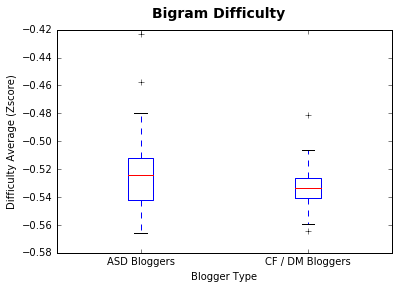

In [41]:
fig = plt.figure()
fig.suptitle('Bigram Difficulty', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot([asdDifficulty.dropna(),cfDmDifficulty.dropna()], labels=["ASD Bloggers", "CF / DM Bloggers"])

ax.set_xlabel('Blogger Type')
ax.set_ylabel('Difficulty Average (Zscore)')

plt.show()

__On the contrary, it seems that ASD bloggers use slightly harder key sequences, with difficulty averages very similar to the mean difficulty average of bloggers with cystic fibrosis or diabetes mellitus.  Note that our sample size is quite small and more research should be done before arriving at any conclusions.__

## Step 3: Pronoun Usage

__What about parts of speech?  Are there important differences there?__

In [42]:
asdPartOfSpeechDicts = []
cfDmPartOfSpeechDicts = []

for text in autismBlogTexts:
    asdPartOfSpeechDicts.append(analyzeTextForPOS(text))
for text in cfDmBlogTexts:
    cfDmPartOfSpeechDicts.append(analyzeTextForPOS(text))
    

In [43]:
asdPosDF = pd.DataFrame(asdPartOfSpeechDicts)
cfDmPosDF = pd.DataFrame(cfDmPartOfSpeechDicts)

__We'll want to have the sum of all parts of speech to see proportions.__

In [44]:
asdPosDF['sum']=asdPosDF.sum(axis=1)
asdPosDF = asdPosDF[asdPosDF["sum"] != 0]

cfDmPosDF['sum']=cfDmPosDF.sum(axis=1)
cfDmPosDF = cfDmPosDF[cfDmPosDF["sum"] != 0]

__We're interested particularly in pronouns: personal pronouns (he, I) are represented by `PRP`, possessive pronouns (my, yours) by `PRP$`, wh-type pronouns (who, whom) by WP, wh-type posessive pronouns (whose) by `WP$`__

In [45]:
pronouns = ["PRP", "PRP$", "WP", "WP$","sum"]

__Let's peek at what our POS data frames look like.  Because the dollar sign causes problems in rendering Jupyter notebooks in GitHub, we'll replace it before proceeding.__

In [58]:
asdPosDF=asdPosDF[pronouns]
asdPosDF=asdPosDF.rename(columns={'PRP': 'personal', 'PRP$': 'possessive', 'WP': 'wh-non-possessive', 'WP$': 'wh-possessive'})
asdPosDF.head()

,personal,possessive,wh-non-possessive,wh-possessive,sum
0,20633,7993,3819,142,595021
1,6986,3253,993,10,139189
2,4113,1038,623,NaN,72782
3,46,15,7,NaN,1007
4,1450,876,351,2,57120


In [59]:
cfDmPosDF=cfDmPosDF[pronouns]
cfDmPosDF=cfDmPosDF.rename(columns={'PRP': 'personal', 'PRP$': 'possessive', 'WP': 'wh-non-possessive', 'WP$': 'wh-possessive'})
cfDmPosDF.head()

,personal,possessive,wh-non-possessive,wh-possessive,sum
0,3404,1708,270,3,67755
1,3234,1906,332,7,62338
4,34474,20685,3323,130,849271
5,998,528,81,NaN,22275
7,994,430,116,1,20889


__Let's create percentage-of-total columns.__

In [60]:
asdPosDF = asdPosDF.join(asdPosDF.div(asdPosDF['sum'], axis=0), rsuffix='_pct')
asdPosDF.head()

,personal,possessive,wh-non-possessive,wh-possessive,sum,personal_pct,possessive_pct,wh-non-possessive_pct,wh-possessive_pct,sum_pct
0,20633,7993,3819,142,595021,0.034676,0.013433,0.006418,0.000239,1
1,6986,3253,993,10,139189,0.050191,0.023371,0.007134,0.000072,1
2,4113,1038,623,NaN,72782,0.056511,0.014262,0.008560,NaN,1
3,46,15,7,NaN,1007,0.045680,0.014896,0.006951,NaN,1
4,1450,876,351,2,57120,0.025385,0.015336,0.006145,0.000035,1


In [61]:
cfDmPosDF = cfDmPosDF.join(cfDmPosDF.div(cfDmPosDF['sum'], axis=0), rsuffix='_pct')
cfDmPosDF.head()

,personal,possessive,wh-non-possessive,wh-possessive,sum,personal_pct,possessive_pct,wh-non-possessive_pct,wh-possessive_pct,sum_pct
0,3404,1708,270,3,67755,0.050240,0.025208,0.003985,0.000044,1
1,3234,1906,332,7,62338,0.051878,0.030575,0.005326,0.000112,1
4,34474,20685,3323,130,849271,0.040592,0.024356,0.003913,0.000153,1
5,998,528,81,NaN,22275,0.044804,0.023704,0.003636,NaN,1
7,994,430,116,1,20889,0.047585,0.020585,0.005553,0.000048,1


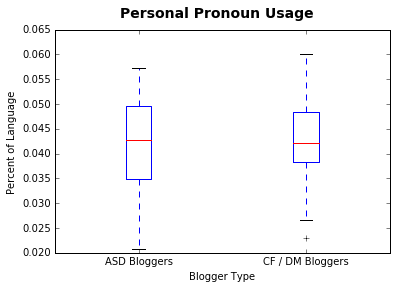

In [62]:
fig = plt.figure()
fig.suptitle('Personal Pronoun Usage', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot([asdPosDF["personal_pct"].dropna(),cfDmPosDF["personal_pct"].dropna()], labels=["ASD Bloggers", "CF / DM Bloggers"])

ax.set_xlabel('Blogger Type')
ax.set_ylabel('Percent of Language')

plt.show()

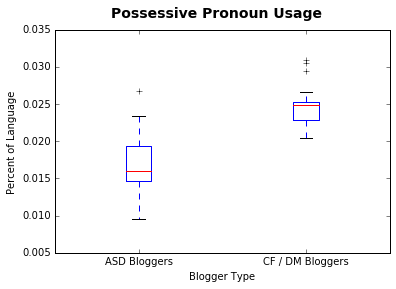

In [63]:
fig = plt.figure()
fig.suptitle('Possessive Pronoun Usage', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot([asdPosDF["possessive_pct"].dropna(),cfDmPosDF["possessive_pct"].dropna()], labels=["ASD Bloggers", "CF / DM Bloggers"])

ax.set_xlabel('Blogger Type')
ax.set_ylabel('Percent of Language')

plt.show()

__Let's look at this in a different way, to see what we can see about the distribution.__

[None, None, None, None, None, None, None, None]

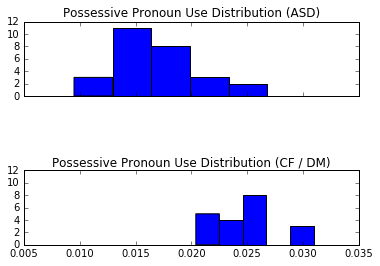

In [65]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.hist(asdPosDF["possessive_pct"].dropna(), bins = 5)
ax1.set_title('Possessive Pronoun Use Distribution (ASD)')
ax2.hist(cfDmPosDF["possessive_pct"].dropna(), bins = 5)
ax2.set_title('Possessive Pronoun Use Distribution (CF / DM)')

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

__Is this significant?  Sure looks it... but let's do a T-test. Keep in mind that our distributions aren't quite normal, but the difference is such that even a parametric measure like a T-test should find significance.__

In [66]:
from scipy.stats import ttest_ind
ttest_ind(asdPosDF["possessive_pct"].dropna(),cfDmPosDF["possessive_pct"].dropna())

Ttest_indResult(statistic=-7.4424594429777535, pvalue=2.2597316443781928e-09)

__This is very significant.  Keep in mind that the small sample size suggests we should repeat this comparison for larger datasets.__

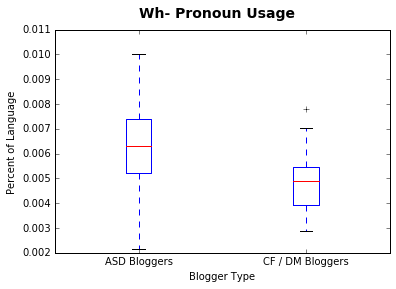

In [67]:
fig = plt.figure()
fig.suptitle('Wh- Pronoun Usage', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot([asdPosDF["wh-non-possessive_pct"].dropna(),cfDmPosDF["wh-non-possessive_pct"].dropna()], labels=["ASD Bloggers", "CF / DM Bloggers"])

ax.set_xlabel('Blogger Type')
ax.set_ylabel('Percent of Language')

plt.show()

__Is this significant?  The boxplot is suggestive.  Let's do a T-test.__

In [68]:
ttest_ind(asdPosDF["wh-non-possessive_pct"].dropna(),cfDmPosDF["wh-non-possessive_pct"].dropna())

Ttest_indResult(statistic=2.6082301326853723, pvalue=0.012307236087649937)

__This is significant.  We should check this on a larger dataset, as it has a p value that could easily move into non-significance.__

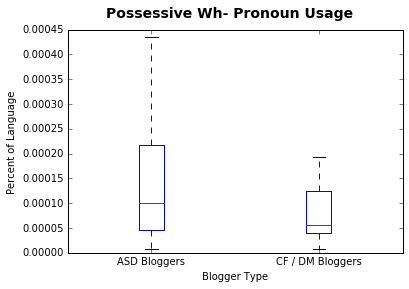

In [69]:
fig = plt.figure()
fig.suptitle('Possessive Wh- Pronoun Usage', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot([asdPosDF["wh-possessive_pct"].dropna(),cfDmPosDF["wh-possessive_pct"].dropna()], labels=["ASD Bloggers", "CF / DM Bloggers"])

ax.set_xlabel('Blogger Type')
ax.set_ylabel('Percent of Language')

plt.show()

In [71]:
# Non-significant as demonstrated by T test:
ttest_ind(asdPosDF["wh-possessive_pct"].dropna(),cfDmPosDF["wh-possessive_pct"].dropna())

Ttest_indResult(statistic=1.7243315143731544, pvalue=0.094607920788540661)

__The most striking difference is between the use of possessive pronouns, which is markedly higher in CF / DM bloggers than in ASD bloggers.  Additional investigation may be warranted to examine the apparent greater use of wh- pronouns by ASD bloggers.__